In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
import wfdb
import os


In [7]:
# Define Bandpass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocess ECG Segment
def preprocess_ecg_segment(segment, fs=100, lowcut=0.5, highcut=48):
    filtered = butter_bandpass_filter(segment, lowcut, highcut, fs)
    mean = np.mean(filtered)
    std = np.std(filtered)
    if std == 0:  # Avoid division by zero
        std = 1
    normalized = (filtered - mean) / std
    return normalized

In [15]:
# Process Single File
def process_file(record_name, data_path):
    ecg_data = []
    labels = []

    # Load ECG signal and annotations
    record_path = os.path.join(data_path, record_name)
    signal, fields = wfdb.rdsamp(record_path)
    annotation = wfdb.rdann(record_path, 'apn')

    # Process each 1-minute segment
    for i in range(len(annotation.symbol)):
        start_idx = i * 6000
        end_idx = start_idx + 6000

        if end_idx > len(signal):  # Skip incomplete segments
            print(f"Skipping incomplete segment in {record_name} at index {i}")
            break

        segment = signal[start_idx:end_idx, 0]  # Single-lead ECG
        label = 1 if annotation.symbol[i] == 'A' else 0  # Apnea (A) or Normal (N)

        processed_segment = preprocess_ecg_segment(segment)
        ecg_data.append(processed_segment)
        labels.append(label)

    return np.array(ecg_data), np.array(labels)

# Process All Files
def process_all_files(file_list, data_path, output_path, split_name):
    all_data = []
    all_labels = []

    for file in file_list:
        print(f"Processing file: {file}")
        data, labels = process_file(file, data_path)
        all_data.append(data)
        all_labels.append(labels)

    # Concatenate data and labels from all files
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Save as .npy files
    np.save(os.path.join(output_path, f"ecg_{split_name}.npy"), all_data)
    np.save(os.path.join(output_path, f"{split_name}_labels.npy"), all_labels)

    print(f"{split_name.capitalize()} data saved. Shape: {all_data.shape}")
    return all_data.shape

In [ ]:
# File Lists
train_files = [f"a{str(i).zfill(2)}" for i in range(1, 21)] + [f"b{str(i).zfill(2)}" for i in range(1, 6)] + [f"c{str(i).zfill(2)}" for i in range(1, 11)]
test_files = [f"x{str(i).zfill(2)}" for i in range(1, 36)]


# Paths to Apnea-ECG data and output
data_path = "/apnea-ecg/1.0.0/"  # Replace with the path to your data
output_path = "/apnea-ecg/1.0.0/"  # Replace with the path to save .npy files

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Run processing
# Process Training and Testing Files
train_shape = process_all_files(train_files, data_path, output_path, "train")
test_shape = process_all_files(test_files, data_path, output_path, "test")

In [18]:
BATCH_SIZE = 32
ecg_train = np.load("ecg_train.npy")
ecg_test = np.load("ecg_test.npy")
train_labels = np.load("train_labels.npy")
test_labels = np.load("test_labels.npy")

ecg_train = np.expand_dims(ecg_train, axis=1)
ecg_test = np.expand_dims(ecg_test, axis=1)
print('Size of training data: {}'.format(ecg_train.shape))
print('Size of testing data: {}'.format(ecg_test.shape))

Size of training data: (17023, 1, 6000)
Size of testing data: (17248, 1, 6000)


In [21]:
class Dataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(int)  # Replace np.int with int
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


In [22]:
train_X,test_X, train_y, test_y = train_test_split(ecg_train,train_labels,test_size = 0.2,random_state = 42)

train_set = Dataset(train_X,  train_y)
val_set = Dataset(test_X, test_y)
test_set = Dataset(ecg_test, test_labels)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)  # only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


In [23]:
drop = 0.3
class Model(nn.Module):
    def __init__(self, ):
        super(Model, self).__init__()

        self.cnnlayer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )

        self.cnnlayer3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer4 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer5 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer6 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer7 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer8 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer9 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )
        self.cnnlayer10 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=32 ,padding = 16),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=drop)
        )

    def forward(self, x):
        x = self.cnnlayer1(x)
        x = self.cnnlayer2(x)
        x = self.cnnlayer3(x)
        x = self.cnnlayer4(x)
        x = self.cnnlayer5(x)
        x = self.cnnlayer6(x)
        x = self.cnnlayer7(x)
        x = self.cnnlayer8(x)
        x = self.cnnlayer9(x)
        x = self.cnnlayer10(x)

        return x
class Transformer(nn.Module):
    def __init__(self, ):
        super(Transformer, self).__init__()
        self.precnnlayer = Model()
        encoder_layers = nn.TransformerEncoderLayer(d_model=64, nhead=1, dim_feedforward=128,
                                                    dropout=0.30)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=2,
                                                         norm=nn.LayerNorm(64))

        self.pred_layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.precnnlayer(x)
        x = x.permute(2, 0, 1)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0)
        x = F.avg_pool1d(x, kernel_size=x.size()[2])
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.pred_layer(x)
        return x

In [25]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

cuda


In [28]:
# fix random seed for reproducibility
same_seeds(42)
# training parameters
num_epoch = 20  # number of training epoch
learning_rate = 0.001  # learning rate
# the path where checkpoint saved
model_path = './1minbestmodel.ckpt'
# create model, define a loss function, and optimizer
model = Transformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-8)
best = 0.0
best_test = 0.0

C:\Users\abbas\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train()  # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        #         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1)  # get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()
        #         print(train_pred.cpu().sum(),labels.cpu().sum())
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    predict = []
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            _, val_pred = torch.max(outputs, 1)

            for m in val_pred.cpu().numpy():
                predict.append(m)
            val_acc += (val_pred.cpu() == labels.cpu()).sum().item()# get the index of the class with the highest probability
            val_loss += batch_loss.item()
        #
        # train_loss_list.append(train_loss/ len(train_loader))
        # train_acc_list.append(train_acc / len(train_set))
        # val_loss_list.append(val_loss/ len(val_loader))
        # val_acc_list.append(val_acc / len(val_set))

        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc / len(train_set), train_loss / len(train_loader),
            val_acc / len(val_set), val_loss / len(val_loader)
        ))

        predict = np.array(predict)
        predict_val= predict.reshape(predict.shape[0], 1)
        labelsval = test_y.reshape(test_y.shape[0], 1)
        cm = confusion_matrix(labelsval, predict_val)
        acc = (cm[1,1]+cm[0,0])/(cm[1,1]+cm[1,0]+cm[0,0]+cm[0,1])
        sen = cm[1,1]/(cm[1,1]+cm[1,0])
        spe = cm[0,0]/(cm[0,0]+cm[0,1])
        pre = cm[1,1]/(cm[1,1]+cm[0,1])
        avg = (acc+sen+pre)/3
        print('VAL:acc= {:.3f} sen = {:.3f} spe = {:.3f} pre = {:.3f} avg = {:.3f}'.format(acc,sen,spe,pre,avg))
        # if the model improves, save a checkpoint at this epoch
        
        if avg > best:
            best = avg
            torch.save(model.state_dict(), model_path)
            print('save model',cm)
            # print('acc= {:.3f} sen = {:.3f} spe = {:.3f}'.format(acc,spe,sen))

    model.load_state_dict(torch.load(model_path))
    test_predict = []
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(test_loader):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, test_pred = torch.max(outputs, 1)

            for y in test_pred.cpu().numpy():
                test_predict.append(y)
    test_predict = np.array(test_predict)
    predict_test = test_predict.reshape(test_predict.shape[0], 1)
    labels_test = test_labels.reshape(test_labels.shape[0], 1)
    test_cm = confusion_matrix(labels_test, predict_test)
    test_acc = (test_cm[1, 1] + test_cm[0, 0]) / (test_cm[1, 1] + test_cm[1, 0] + test_cm[0, 0] + test_cm[0, 1])
    test_sen = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    test_spe = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])
    test_pre = test_cm[1, 1] / (test_cm[1, 1] + test_cm[0, 1])
    test_avg = (test_acc  + test_sen + test_pre) / 3
    print('TESTacc= {:.3f} sen = {:.3f} spe = {:.3f} pre = {:.3f} avg = {:.3f}'.format(test_acc, test_sen,test_spe, test_pre,test_avg))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

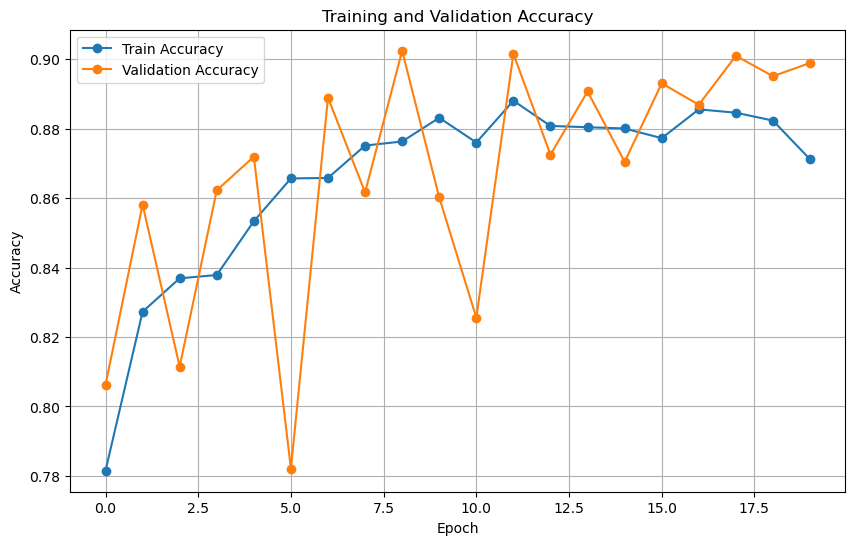

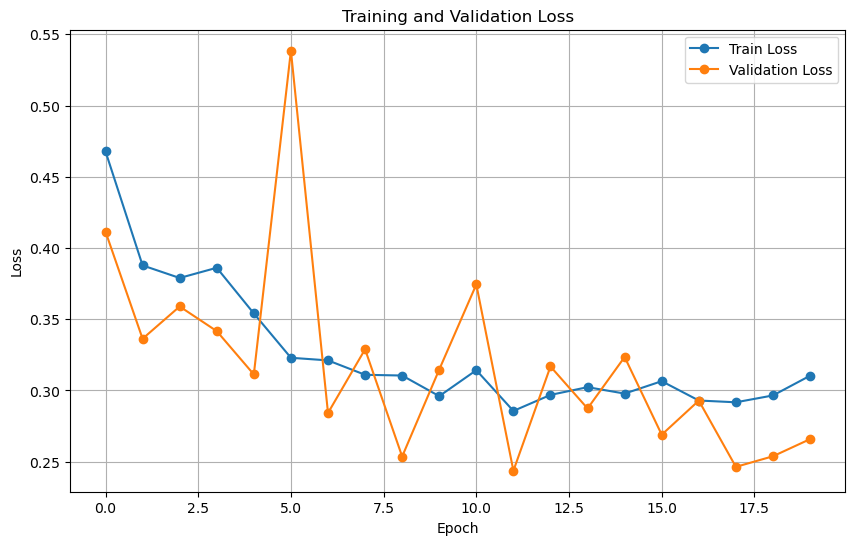

In [31]:

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_acc_list, label='Train Accuracy', marker='o')
plt.plot(val_acc_list, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Train Loss', marker='o')
plt.plot(val_loss_list, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1

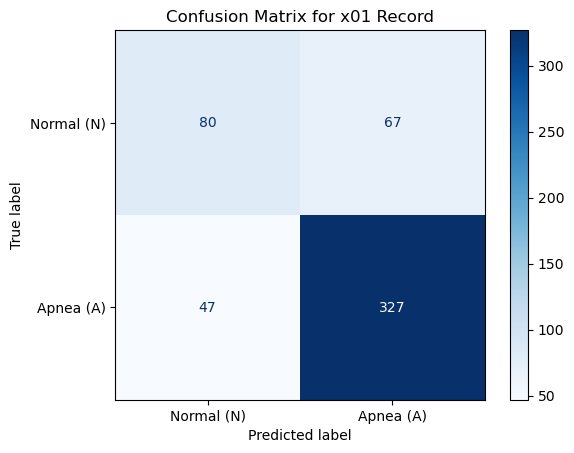


Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.54      0.58       147
       Apnea       0.83      0.87      0.85       374

    accuracy                           0.78       521
   macro avg       0.73      0.71      0.72       521
weighted avg       0.77      0.78      0.78       521



In [32]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# True labels provided as a string
true_labels_str = (
    "NNNNNNNNNNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNN"
    "NNNAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNNNNNAAAAA"
    "AANAAAAAAAAAAAAAAAAANNAAAAANNAANNAAAAAAAAAAAAAAAAAAAAAAAAAAA"
    "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNANNNANNNNNNNNNN"
    "NNNNNNNNNNNAAAAAAAAAAAAAAAAAAAANAAAAAAAAAAAAAAAAAAAAAAANAAA"
    "AAAAAAAANNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"
    "AAAAAAAAAAAAAAAAANAANAAAAAAAAAAAAAAAANNNNNNAAANNNNNAAANNNNN"
    "NNNAANNNNAAAAAAAAAAAAAAAAAAAAAAANNAAAAAAAAAAAAAAAAAAAAAAAAAA"
    "ANNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANNNANN"
)

# Convert true labels to numerical format: 0 (Normal) and 1 (Apnea)
true_labels = np.array([0 if label == 'N' else 1 for label in true_labels_str])

# Extract x01 data from the test set
x01_data = ecg_test[:len(true_labels)]  # Assuming ecg_test contains test data

# Initialize a list to store predictions
predicted_labels = []

# Make predictions
with torch.no_grad():
    x01_data_tensor = torch.from_numpy(x01_data).float().to(device)  # Convert to tensor and move to device
    outputs = model(x01_data_tensor)  # Forward pass
    _, preds = torch.max(outputs, 1)  # Get the predicted class
    predicted_labels = preds.cpu().numpy()  # Move predictions to CPU and convert to numpy

# Print True Labels
print("True Labels:")
print(true_labels)

# Print Predicted Labels
print("Predicted Labels:")
print(predicted_labels)

# Compare True and Predicted Labels Side by Side
comparison_df = pd.DataFrame({
    'True Labels': true_labels,
    'Predicted Labels': predicted_labels
})
print("\nComparison of True and Predicted Labels:")
print(comparison_df)

# Save comparison to a CSV file
comparison_df.to_csv("x01_label_comparison.csv", index=False)
print("\nComparison saved to x01_label_comparison.csv.")

# Generate and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (N)', 'Apnea (A)'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for x01 Record")
plt.show()

# Print Classification Report
print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=['Normal', 'Apnea'])
print(report)


True Labels for x02:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels for x02:
[1 1 1 1 1 

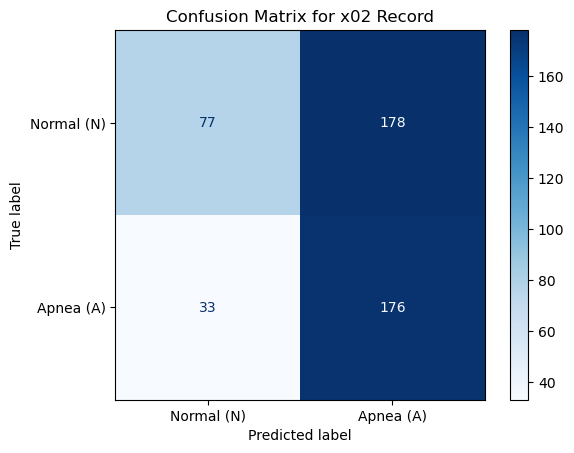


Classification Report for x02:
              precision    recall  f1-score   support

      Normal       0.70      0.30      0.42       255
       Apnea       0.50      0.84      0.63       209

    accuracy                           0.55       464
   macro avg       0.60      0.57      0.52       464
weighted avg       0.61      0.55      0.51       464



In [33]:
# Define the true labels for x02
true_labels_str_x02 = (
    "NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"
    "NNNNNNNNAAAAANNNNNNNNAAAAAAAAAAAAAAAAAANNAANNNNNNNNNNNNNNNN"
    "NNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNNNNNNN"
    "NNNNNNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAANNNNNNNNNNNNNNNN"
    "NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAAAAAAAAAAAA"
    "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"
    "ANNNNNNNNNNNAAAAAAAAAAAAAAAAAAAANNNNNNNNAAAAAAANNNNNNNNNNNNN"
    "NNNNNNNNNNNNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"
)

# Convert true labels for x02 to numerical format: 0 (Normal) and 1 (Apnea)
true_labels_x02 = np.array([0 if label == 'N' else 1 for label in true_labels_str_x02])

# Extract x02 data from the test set
x02_data = ecg_test[:len(true_labels_x02)]  # Assuming ecg_test contains the segmented test data

# Initialize a list to store predictions
predicted_labels_x02 = []

# Make predictions for x02
with torch.no_grad():
    x02_data_tensor = torch.from_numpy(x02_data).float().to(device)  # Convert to tensor and move to device
    outputs = model(x02_data_tensor)  # Forward pass
    _, preds = torch.max(outputs, 1)  # Get the predicted class
    predicted_labels_x02 = preds.cpu().numpy()  # Move predictions to CPU and convert to numpy

# Print True Labels for x02
print("True Labels for x02:")
print(true_labels_x02)

# Print Predicted Labels for x02
print("Predicted Labels for x02:")
print(predicted_labels_x02)

# Compare True and Predicted Labels Side by Side for x02
comparison_df_x02 = pd.DataFrame({
    'True Labels': true_labels_x02,
    'Predicted Labels': predicted_labels_x02
})
print("\nComparison of True and Predicted Labels for x02:")
print(comparison_df_x02)

# Save comparison to a CSV file for x02
comparison_df_x02.to_csv("x02_label_comparison.csv", index=False)
print("\nComparison for x02 saved to x02_label_comparison.csv.")

# Generate and Display Confusion Matrix for x02
cm_x02 = confusion_matrix(true_labels_x02, predicted_labels_x02)
disp_x02 = ConfusionMatrixDisplay(confusion_matrix=cm_x02, display_labels=['Normal (N)', 'Apnea (A)'])
disp_x02.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for x02 Record")
plt.show()

# Print Classification Report for x02
print("\nClassification Report for x02:")
report_x02 = classification_report(true_labels_x02, predicted_labels_x02, target_names=['Normal', 'Apnea'])
print(report_x02)
